#Dependencies

In [1]:
%%capture
!pip install pm4py
!pip install gdown==4.2.0
!gdown https://drive.google.com/drive/folders/1rpjmi83nQGkYVkiQLvYKfWHBxi5k_7g4 -O /content/folder --folder

In [2]:
import pm4py
import pytz
from collections import defaultdict
from lxml import etree, objectify
from pm4py.objects.log import log as lg
from pm4py.objects.log.importer.xes import importer as xes_importer
import matplotlib.pyplot as plt
import time
import datetime

/usr/local/lib/python3.7/dist-packages/pm4py/objects/log/log.py:19: UserWarning: pm4py.objects.log.log is deprecated. please use the class pm4py.objects.log.obj instead
  warnings.warn("pm4py.objects.log.log is deprecated. please use the class pm4py.objects.log.obj instead")


In [3]:
list_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
utc = pytz.UTC
time_unit = 1440
log_file_name = '/content/folder/ConsultaDataMining201618.xes'

#Log Extraction

In [4]:
def from_text_to_log(input_file_path):
    input_file = open(input_file_path, 'r')
    input_file.readline() # skip first line
    log=lg.EventLog()
    traces=dict()
    for line in input_file:
        line=line.replace(",", "")
        res = line.strip().split('\t')
        if len(res) == 8:
          a,b,c,d,e,f,g,h = res[0],res[1],res[2],res[3],res[4],res[5],res[6],res[7]

          c = c.replace(".","")
          if int(c) not in traces:
              new_case=lg.Trace()
              new_case._set_attributes({'concept:instance':int(c)})
              new_case.insert(int(c),{
                                'concept:instance': c,
                                'concept:name': d,
                                'lifecycle:transition': 'start',
                                'time:timestamp': datetime.datetime.strptime(f,"%Y-%m-%d %H:%M:%S").replace(tzinfo=utc),
                                'org:resource': h})
              traces[int(c)]=new_case
              traces[int(c)].append({
                                'concept:instance': c,
                                'concept:name': d,
                                'lifecycle:transition': 'complete',
                                'time:timestamp': datetime.datetime.strptime(g,"%Y-%m-%d %H:%M:%S").replace(tzinfo=utc),
                                'org:resource': h})
          else:
              traces[int(c)].append({
                                'concept:instance': c,
                                'concept:name': d,
                                'lifecycle:transition': 'start',
                                'time:timestamp': datetime.datetime.strptime(f,"%Y-%m-%d %H:%M:%S").replace(tzinfo=utc),
                                'org:resource': h})
              traces[int(c)].append({
                                'concept:instance': c,
                                'concept:name': d,
                                'lifecycle:transition': 'complete',
                                'time:timestamp': datetime.datetime.strptime(g,"%Y-%m-%d %H:%M:%S").replace(tzinfo=utc),
                                'org:resource': h})

    for trace in traces:
        log.append(traces[trace])
    return log

In [5]:
log_file = []
if log_file_name.endswith('log'):
  log_file = from_text_to_log(log_file_name)
elif log_file_name.endswith('xes'):
  log_file = xes_importer.apply(log_file_name)

if log_file_name.endswith('ConsultaDataMining201618.xes'):
  delta_6 = datetime.timedelta(seconds = 21600)
  for i in range(len(log_file)):
    for j in range(len(log_file[i])):
      log_file[i][j]['time:timestamp'] = log_file[i][j]['time:timestamp'] - delta_6

parsing log, completed traces ::   0%|          | 0/954 [00:00<?, ?it/s]

#Role Discovery

In [6]:
from pm4py.algo.organizational_mining.roles import algorithm as roles_discovery
roles = roles_discovery.apply(log_file)
role_list = []
for r in roles:
  role_list.append(r[0])
role_list

[['Avanzar recepcion documentos', 'Recepcion de documentos'],
 ['Cancelar Solicitud', 'Notificacion estudiante cancelacion soli'],
 ['Cancelar curso'],
 ['End'],
 ['Evaluacion curso'],
 ['Homologacion por grupo de cursos'],
 ['Radicar Solicitud Homologacion', 'Traer informacion estudiante - banner'],
 ['Revisar curso'],
 ['Start'],
 ['Transferir Creditos'],
 ['Transferir creditos homologables'],
 ['Validacion final'],
 ['Validar solicitud'],
 ['Validar solicitud / pre-homologacion'],
 ['Visto Bueno Cierre Proceso']]

#Filter Event Log by Role

In [7]:
def create_timetable_role(log, activity_role):
  log_resource = []
  
  #filter in only events of activity completed by the resources in the role
  for case in log:
    case_list = []
    for event in case:
      if event['concept:name'] in activity_role:
        case_list.append(event)
    if len(case_list) > 0:
      log_resource.append(case_list)

  result = defaultdict(list)
  error = []
  
  #merge start and complete event
  for case in log_resource:
    for index_start, event_start in enumerate(case):
      #add new entry in dict only if it's a new start event
      if event_start['lifecycle:transition']=='start':
        case_id = event_start['case:concept:name']
        activity = event_start['concept:name']
        start = event_start['time:timestamp']
        resource = event_start['org:resource']
        complete = 'complete'
        for index_complete in range(index_start + 1, len(case)):
          if case[index_complete]['concept:name']==activity and case[index_complete]['lifecycle:transition']==complete and case[index_complete]['org:resource'] == resource:
            complete = case[index_complete]['time:timestamp']
            break
        
        if complete != 'complete':
          result[resource].append({'concept:name' : activity, 'start': start, 'complete': complete, 'case:concept:name': case_id})          
        #could not find matching complete event
        else:
          error.append(event_start)

  return (result, error)

#Filter Event Log by Same Date Activity

In [8]:
def create_timetable_same_date(log):
  result = []
  for keys in log:
    for entry in log[keys]:
      if entry['start'].date() == entry['complete'].date():
        result.append(entry)
  return result

#Split Event Log by Day of the Week 

In [9]:
def to_time_unit(current_date):
  #Python 3.10
  """
  match time_unit:
    case 24:
      return current_date.hour
    
    case 1440:
      return (current_date.hour * 60) + current_date.minute

    case 86400:
      return (current_date.hour * 3600) + (current_date.minute * 60) + current_date.second

    case default:
      return (current_date.hour * 60) + current_date.minute
  """
  return (current_date.hour * 60) + current_date.minute

def split_event_log(log):
  calendars = {'Monday': [], 'Tuesday': [], 'Wednesday': [], 'Thursday': [], 'Friday': [], 'Saturday': [], 'Sunday': []}

  for entry in log:
    date_start = time.strftime("%A", time.strptime(str(entry['start'].date()), "%Y-%m-%d"))
    calendars[date_start].append({'start': to_time_unit(entry['start']), 'complete': to_time_unit(entry['complete']) + 1})
  
  return calendars

#Discover Calendar from Event Log

In [10]:
def find_calendar(log, threshold, tolerance): #log filtered by day of the week
  activities = [0]*(time_unit + 1)
  for entry in log:
    if (entry['complete'] - entry['start']) >= 1:
      for i in range(entry['start'], entry['complete'] + 1):
        activities[i] = activities[i] + 1

  intervals = []
  start = 0
  end = 0
  current_interval = 0
  idx = 0
  search = False

  while idx <= time_unit:
    if activities[idx] > 0 and search == False: #Found start of interval
      start = idx
      search = True
      current_interval = current_interval + activities[idx]

    elif activities[idx] > 0 and search == True: #Already inside an interval found
      current_interval = current_interval + activities[idx]

    elif activities[idx] <= 0 and search == True: #Possible end of interval
      patience = 0
      found = False
      while patience < tolerance and (patience + idx) <= time_unit:
        if activities[idx + patience] > 0:
          found = True
          break #Found beginning of second interval
        patience = patience + 1
      
      if found == True: #Merge two intervals together
        idx = idx + patience
        current_interval = current_interval + activities[idx]
      else: #Found end of current interval
        current_ratio = current_interval / sum(activities)
        if (current_ratio - threshold) >= 0.001:
          intervals.append((start, idx - 1))
        current_interval = 0
        search = False
    idx = idx + 1

  if search == True: #Edge case in which the interval ends at 24:00
    current_ratio = current_interval / sum(activities)
    if (current_ratio - threshold) >= 0.001:
          intervals.append((start, idx - 1)) 
 
  return intervals

#Hyperparameter Optimization

In [11]:
def precision(log, intervals):
  total_duration_covered = 0
  for duration in intervals:
    total_duration_covered = total_duration_covered + (duration[1] - duration[0])

  activities = [0]*(time_unit + 1)
  for entry in log:
    if (entry['complete'] - entry['start']) >= 1:
      for i in range(entry['start'], entry['complete'] + 1):
        activities[i] = activities[i] + 1

  expected_by_calendar = 0
  for tup in intervals:
    start = tup[0]
    complete = tup[1]
    for i in range(start, complete + 1):
      if activities[i] == 0: #Activities not in Event Log, but expected in calendar
        expected_by_calendar = expected_by_calendar + 1
  
  result = expected_by_calendar / total_duration_covered
  result = 1 - result

  return result

In [12]:
def recall(log, intervals):
  activities_in_event_log = len(log)
  activities_covered_by_calendar = 0
  for entry in log:
    for tup in intervals:
      start = tup[0]
      complete = tup[1]
      if entry['start'] >= start and entry['complete'] <= complete:
        activities_covered_by_calendar = activities_covered_by_calendar + 1
        break
  result = activities_covered_by_calendar / activities_in_event_log
  return result

In [13]:
def F_score(log, intervals):  
  prec = precision(log, intervals)
  rec = recall(log, intervals)
  
  mul = prec * rec
  sum = prec + rec
  
  if sum > 0:
    return 2 * (mul / sum)
  else:
    return 0

In [14]:
def sum_inter(intervals):
  sum_hour = 0
  for tup in intervals:
    start = tup[0]
    complete = tup[1]
    if start < complete:
      sum_hour = sum_hour + complete - start
  result = sum_hour / time_unit
  return sum_hour

In [15]:
def grid_search(log, threshold= 0.30, tolerance = 30):  
  result = []
  best_gamma = 0

  threshold = int(threshold * 100)
  for thr in range(10, threshold + 1):
    thr = thr / 100
    for tol in range(1, tolerance + 1):
      intervals = find_calendar(log, thr, tol)
      
      if len(intervals) > 0:
        F = F_score(log, intervals)
        gamma = F - len(intervals)/24 + sum_inter(intervals)
        
        if gamma > best_gamma:
          best_gamma = gamma
          result = intervals

  return result

#Plot Calendar

In [16]:
def plot_calendar(log, intervals):
  yy = [0]*(time_unit + 1)
  for entry in log:
    if (entry['complete'] - entry['start']) >= 1:
      for i in range(entry['start'], entry['complete'] + 1):
        yy[i] = yy[i] + 1

  plt.rcParams["figure.figsize"] = (20,10)
  plt.plot(yy, color='green')
  x = []
  for i in range(0,(time_unit + 1),60):
    x.append(i//60)
  plt.xticks(range(0,(time_unit + 1),60), x)

  for tup in intervals:
    plt.axvline(x=tup[0], color='k', linewidth = 5)
    plt.axvline(x=tup[1] - 1, color='k', linewidth = 5)

  plt.show()

#TEST

In [17]:
current_role = role_list[1]

timetable_1, error_1 = create_timetable_role(log_file, current_role)

timetable_2 = create_timetable_same_date(timetable_1)

if len(error_1) == 0:
  print('success: no non-matching event')
else:
  print('error: found non-matching events')

calendar = {}
if len(timetable_2) > 0:
  calendar = split_event_log(timetable_2)
else:
  print('error: no events found for calendar')

current_role

success: no non-matching event


['Cancelar Solicitud', 'Notificacion estudiante cancelacion soli']

In [19]:
for day in list_day:
  print(grid_search(calendar[day]))

[(366, 1399)]
[(419, 1334)]
[(412, 1405)]
[(306, 1324)]
[(420, 1194)]
[(608, 1274)]
[(650, 1395)]


Monday


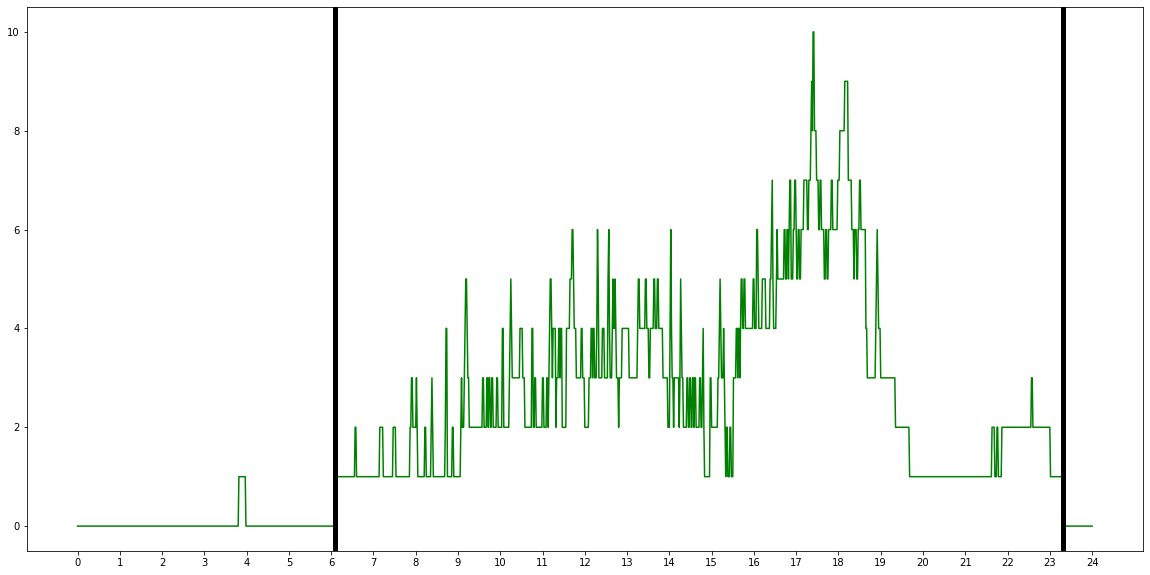

Tuesday


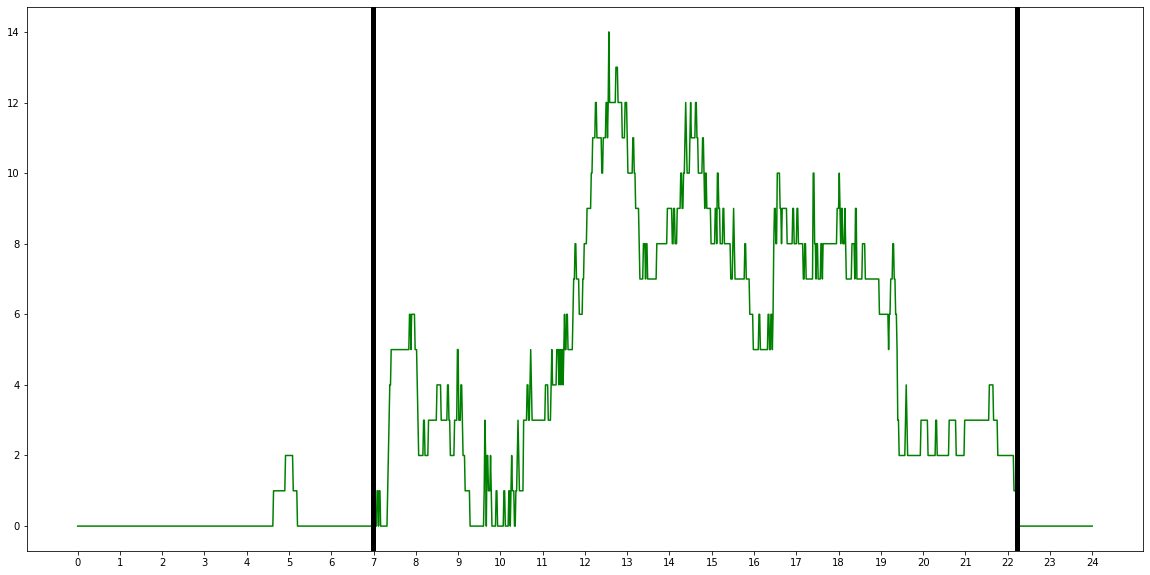

Wednesday


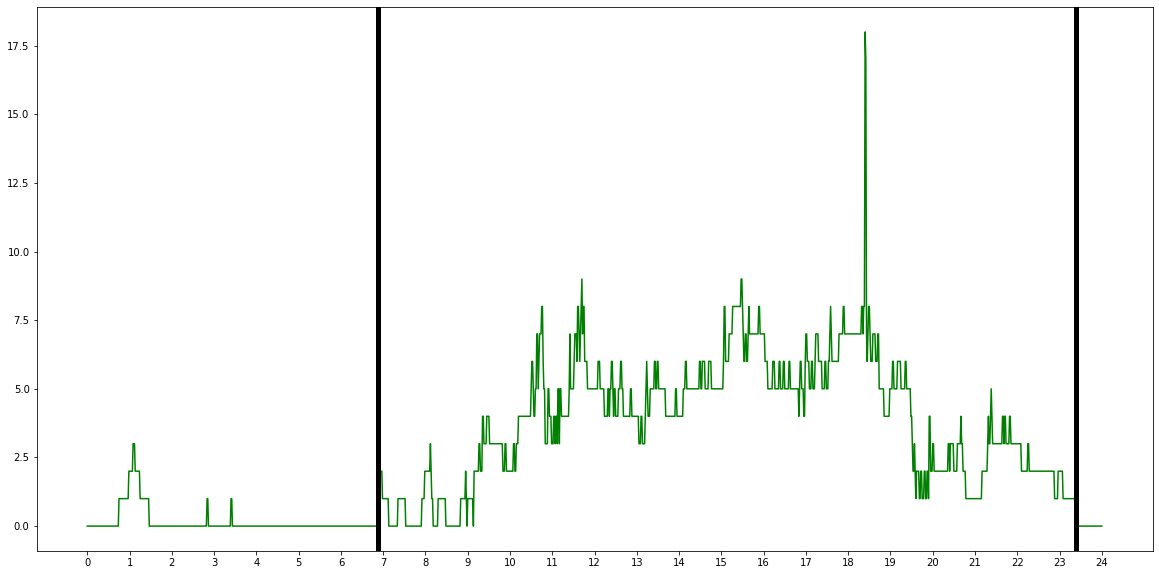

Thursday


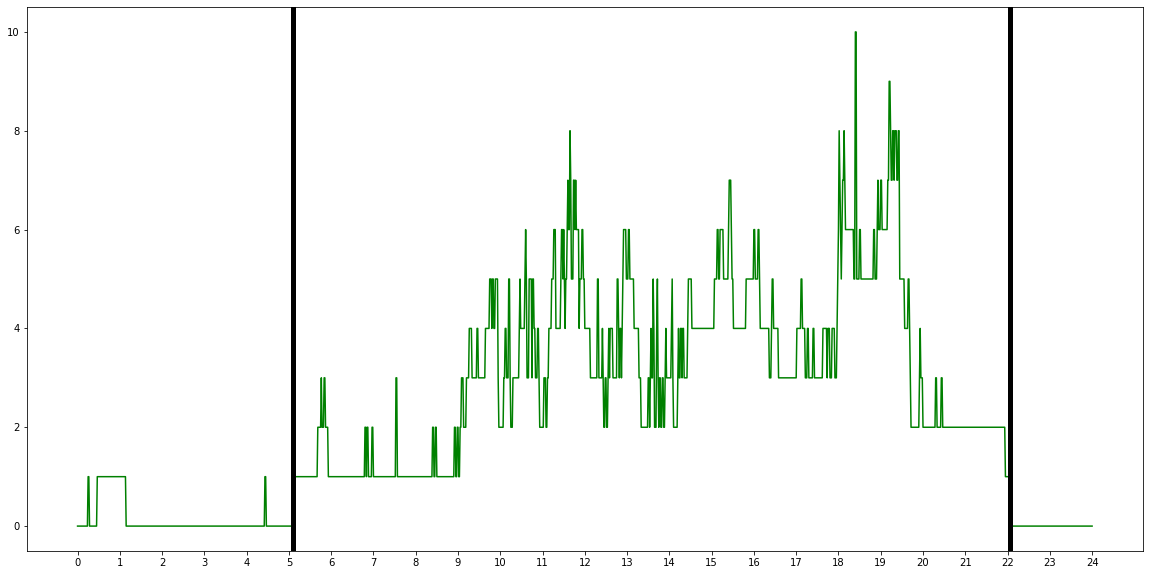

Friday


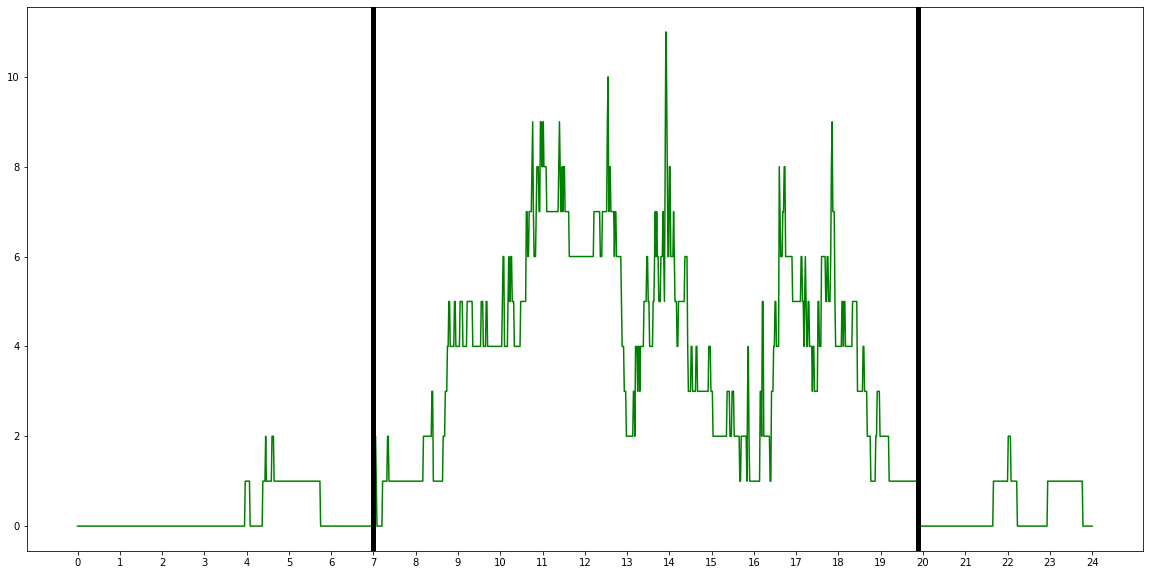

Saturday


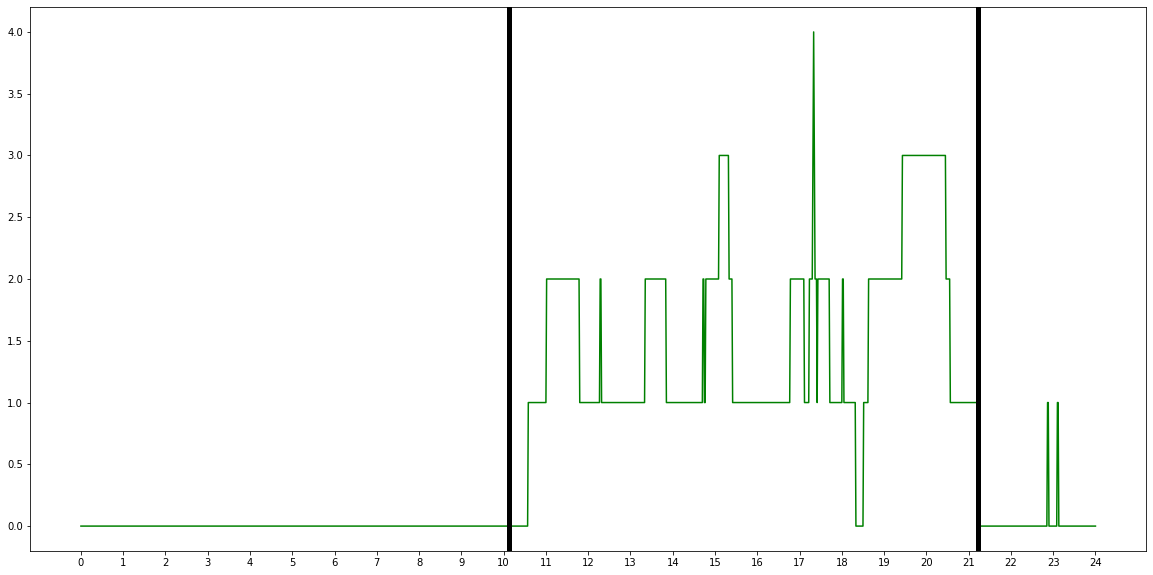

Sunday


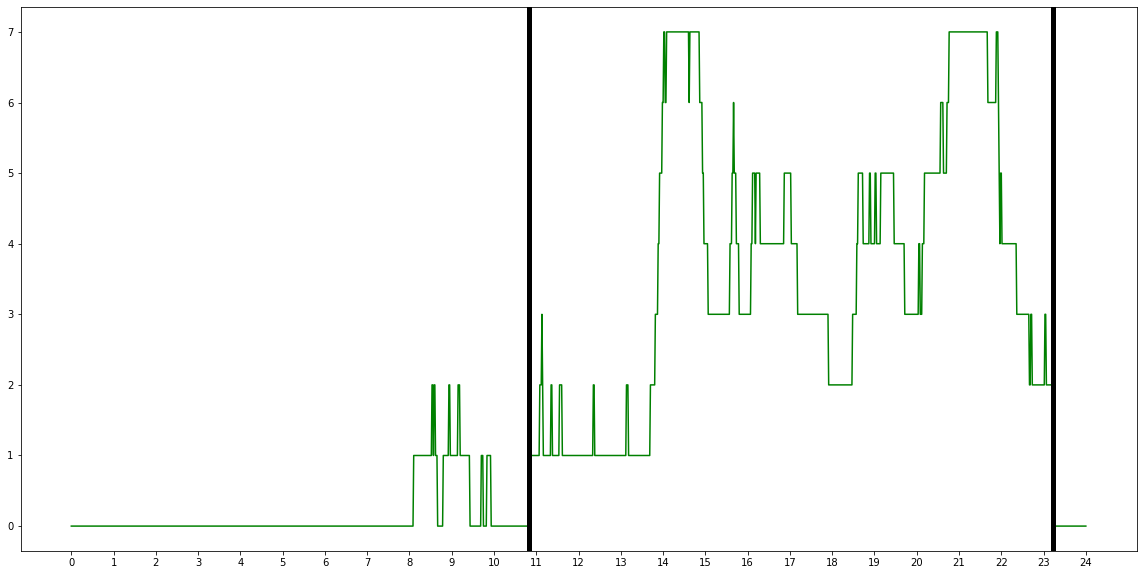

In [20]:
#%%capture
result_calendar = {'Monday': [], 'Tuesday': [], 'Wednesday': [], 'Thursday': [], 'Friday': [], 'Saturday': [], 'Sunday': []}
for day in list_day:
  print(day)
  result_calendar[day] = grid_search(calendar[day])
  plot_calendar(calendar[day],result_calendar[day])

#END